In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install adversarial-robustness-toolbox

  Obtaining dependency information for adversarial-robustness-toolbox from https://files.pythonhosted.org/packages/59/21/6397c16cbf26abc61b070051f9e59af3dcb49fac500eeab1b2732f2bdb31/adversarial_robustness_toolbox-1.16.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 24.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
sys.path.append("..")

%matplotlib inline

import imagenet_stubs
import numpy as np
import keras
from tensorflow.keras.utils import load_img, img_to_array

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from keras.layers import Dense, Flatten
from keras.models import Model
import keras.backend as k
from matplotlib import pyplot as plt
from IPython.display import clear_output

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import BoundaryAttack
from art.utils import to_categorical

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-4go8htig
  Running command git clone --filter=blob:none --quiet https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-4go8htig
  Resolved https://github.com/nottombrown/imagenet_stubs to commit 0b501276f54cbf45b8e1b67dccbdcbe51de88365
  Preparing metadata (setup.py) ... done
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-py3-none-any.whl size=794798 sha256=578fefe28536d196e0859731647713b8aaf88e45e4943726f43990b6188c4d30
  Stored in directory: /tmp/pip-ephem-wheel-cache-shxnwg4t/wheels/11/fe/f6/71c84cfe4ee113c44af28273d506ccbd346c66da9db8688fe6
Successfully built imagenet-stubs


In [3]:
from keras.models import load_model
model = load_model('/kaggle/input/cnn-model/cnn_20_epochs.h5')
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 5s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [4]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [5]:
_, acc, *is_anything_else_being_returned = model.evaluate(X_test, y_test, verbose=1)
print('> %.3f' % (acc * 100.0))

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


> 87.090


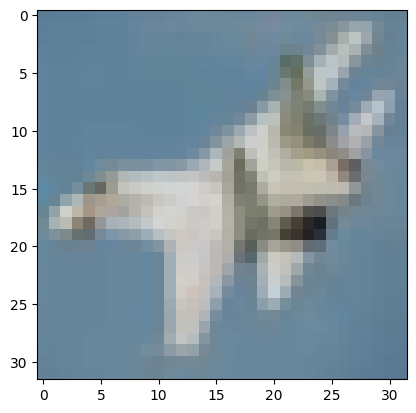

In [6]:
plt.imshow(X_test[10])

In [7]:
mean_cifar10 = np.mean(X_train, axis=(0, 1, 2))
std_cifar10 = np.std(X_train, axis=(0, 1, 2))
# mean_imagenet = np.zeros([224, 224, 3])
# mean_imagenet[...,0].fill(103.939)
# mean_imagenet[...,1].fill(116.779)
# mean_imagenet[...,2].fill(123.68)
# model = ResNet50(weights='imagenet')
classifier = KerasClassifier(
    clip_values=(0, 255),
    model=model,
    preprocessing=(mean_cifar10, std_cifar10)
)

In [9]:
def get_image_predictions(image):
    predictions = classifier.predict(np.array([image]))
    return predictions

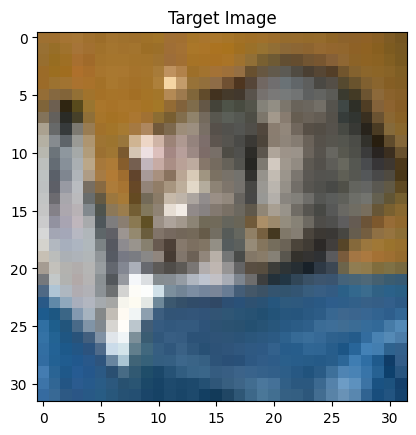

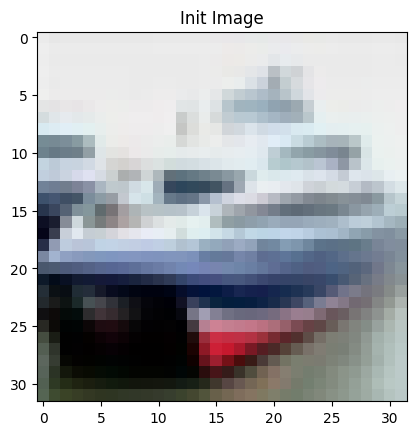

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Target image label: 3 [[0.01902866 0.00679003 0.18358992 0.6788145  0.00077165 0.09910338
  0.00312834 0.00579594 0.0022665  0.00071103]]


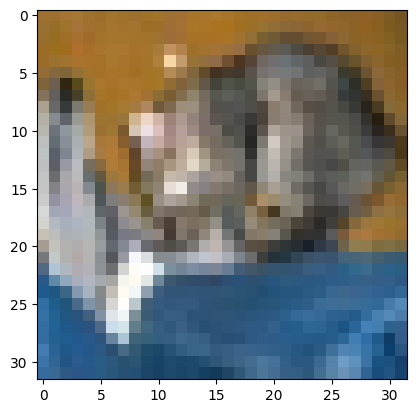

Init image label: 8 [[2.3824582e-03 6.8912092e-03 1.0894339e-06 9.7041211e-06 1.2307179e-08
  3.7280847e-07 4.6011166e-07 4.2575239e-06 9.6959037e-01 2.1120051e-02]]


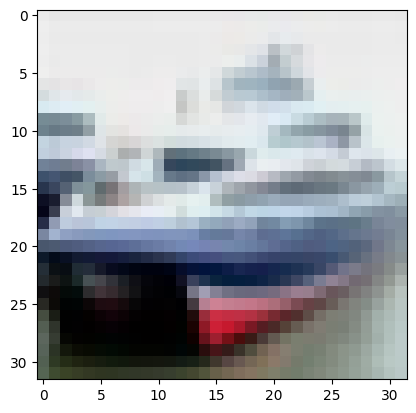

In [10]:
# Choose indices of CIFAR-10 images
target_index = 0  # Replace with the index of the CIFAR-10 image you want as the target
init_index = 1    # Replace with the index of another CIFAR-10 image you want as the init

# Load target and init images
target_image = X_test[target_index]
init_image = X_test[init_index]

# Display target image
plt.imshow(target_image)
plt.title("Target Image")
plt.show()

# Display init image
plt.imshow(init_image)
plt.title("Init Image")
plt.show()

# Get predictions for target and init images
target_predictions = get_image_predictions(target_image)
init_predictions = get_image_predictions(init_image)

print("Target image label:", np.argmax(classifier.predict(np.array([target_image]))[0]), target_predictions)
plt.imshow(target_image)
plt.show()

print("Init image label:", np.argmax(classifier.predict(np.array([init_image]))[0]), init_predictions)
plt.imshow(init_image)
plt.show()

Boundary attack:   0%|          | 0/10000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:01<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:01<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Adversarial image at step 0. L2 error: 4.33, Class label: 2, Class name: [[0.07895341 0.0276465  0.30989653 0.24974649 0.01389045 0.27992192
  0.00980971 0.02431201 0.00388324 0.00193975]]


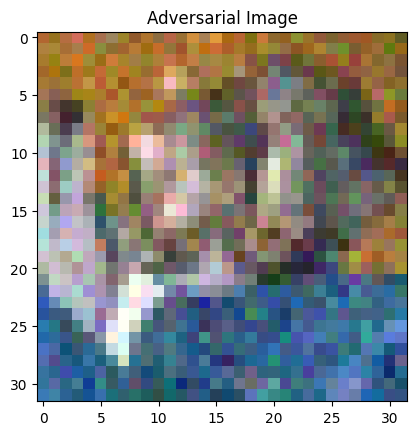

Boundary attack:   0%|          | 0/10000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=20, delta=0.001, epsilon=0.001)
iter_step = 1
x_adv = None

# Generate adversarial examples
for i in range(2):
    x_adv = attack.generate(x=X_test, x_adv_init=x_adv)

    l2_error = np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1]))
    class_label = np.argmax(classifier.predict(x_adv)[0])

    # Get the class predictions for the adversarial image
    class_name = get_image_predictions(x_adv[0])

    print("Adversarial image at step %d. L2 error: %.2f, Class label: %d, Class name: %s" %
          (i * iter_step, l2_error, class_label, class_name))

    plt.imshow(x_adv[0])
    plt.title("Adversarial Image")
    plt.show(block=False)

    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break

In [17]:
_, acc,*is_anything_else_being_returned = model.evaluate(x_adv, y_test, verbose=1)
print('> %.3f' % (acc * 100.0))

> 27.090


In [18]:
np.save('decision_based_adv.npy', x_adv)
np.save('decision_based_y_test_label.npy', y_test)